# Polyphase and NPR Filter Bank with Chirp Functions

This example shows the result of near perfect reconstruction (NPR) and standard polyphase filter banks on channelizing a chirp signal.

In [1]:
from pathlib import Path
import numpy as np
import scipy.signal as sig
from mitarspysigproc import (
    pfb_decompose,
    pfb_reconstruct,
    kaiser_coeffs,
    kaiser_syn_coeffs,
    npr_analysis,
    npr_synthesis,
    rref_coef,
)
import matplotlib.pyplot as plt

In [2]:
def create_chirp(t_len, fs, bw, pad, nchans, nslice):
    """Creates a chirp signal

    Parameters
    ----------
    t_len : float
        Length of chirp in seconds
    fs : float
        Sampling frequency in Hz
    bw : float
        Bandwidth of chirp
    nzeros : tuple
        Number of zeros to pad in the begining and end of the array.
    nchans : int
        Number of channels for the PFB
    nslice : int
        Number of time samples from the pfb

    Returns
    -------
    tout : ndarray
        The time vector for the created signal
    xout : ndarray
        Created signal
    """
    nar = (
        np.arange(int(-nslice * nchans / 2), int(nslice * nchans / 2), dtype=float)
        / nslice
        / nchans
    )
    t = np.linspace(-t_len / 2, t_len / 2, int(t_len * fs))
    dphi = 2 * np.pi * nar * bw / fs
    phi = np.mod(np.cumsum(dphi), 2 * np.pi)
    x = np.exp(-1j * phi)
    # x = sig.chirp(t,t1=t_len,f0=0,f1=bw,method='linear')

    xout = np.concatenate((pad[0], x, pad[1]), axis=0)
    tp1 = -1 * np.arange(0, len(pad[0]), dtype=float)[::-1] / fs - t_len / 2
    tp2 = np.arange(0, len(pad[1]), dtype=float) / fs + t_len / 2
    tout = np.concatenate((tp1, t, tp2), axis=0)

    return tout, xout


def runchirptest(t_len, fs, bw, nzeros, nchans, nslice):
    """Creates a chirp and runs the standard PFB analysis and reconstruction

    Parameters
    ----------
    t_len : float
        Length of chirp in seconds
    fs : float
        Sampling frequency in Hz
    bw : float
        Bandwidth of chirp
    nzeros : int
        Number of zeros to pad
    nchans : int
        Number of channels for the PFB
    nslice : int
        Number of time samples from the pfb

    Returns
    -------
    x_rec : ndarray
        Reconstructed signal
    tin : ndarray
        The time vector for the input signal
    x : ndarray
        Input signal
    x_pfb : ndarray
        The result of the PFB analysis in an nchans x slice array.
    """
    pad = [np.zeros(nzeros), np.zeros(nzeros)]
    t, x = create_chirp(t_len, fs, bw, pad, nchans, nslice)

    coeffs = kaiser_coeffs(nchans, 8.0)
    mask = np.ones(nchans, dtype=bool)
    xout = pfb_decompose(x, nchans, coeffs, mask)
    fillmethod = ""
    fillparams = [0, 0]
    syn_coeffs = kaiser_syn_coeffs(nchans, 8)
    x_rec = pfb_reconstruct(
        xout, nchans, syn_coeffs, mask, fillmethod, fillparams=[], realout=False
    )
    return x_rec, t, x, xout


def runnprchirptest(t_len, fs, bw, nzeros, nchans, nslice, ntaps=64):
    """Creates a chirp and runs the near perfect PFB analysis and reconstruction

    Parameters
    ----------
    t_len : float
        Length of chirp in seconds
    fs : float
        Sampling frequency in Hz
    bw : float
        Bandwidth of chirp
    nchans : int
        Number of channels for the PFB
    nslice : int
        Number of time samples from the pfb

    Returns
    -------
    x_rec : ndarray
        Reconstructed signal
    tin : ndarray
        The time vector for the input signal
    x : ndarray
        Input signal
    x_pfb : ndarray
        The result of the PFB analysis in an nchans x slice array.
    """
    pad = [np.zeros(nzeros), np.zeros(nzeros)]
    t, x = create_chirp(t_len, fs, bw, pad, nchans, nslice)
    coeffs = rref_coef(nchans, ntaps)
    mask = np.ones(nchans, dtype=bool)
    xout = npr_analysis(x, nchans, coeffs)
    fillmethod = ""
    fillparams = [0, 0]
    x_rec = npr_synthesis(xout, nchans, coeffs)
    return x_rec, t, x, xout


def nexpow2(x):
    """Returns the next power of two.

    Parameters
    ----------
    x : int
        Inital number.

    Returns
    -------
    int
        The next power of two of x.
    """

    return int(np.power(2, np.ceil(np.log2(x))))


def plotdata(x, x_rec, tin, tout, g_del=0):
    """Plot the data and return the figure.

    Parameters
    ----------
    x : ndarray
        Input signal
    x_rec : ndarray
        Reconstructed signal
    tin : ndarray
        The time vector for the input signal
    tout : ndarray
        The time vector for the output signal

    Returns
    -------
    fig : matplotlib.fig
        The matplotlib fig for plotting or saving.
    """

    fig, ax = plt.subplots(3, 1, figsize=(10, 5))

    inlen = x.shape[0]
    outlen = x_rec.shape[0]
    tau = tin[1] - tin[0]

    ax[0].plot(tin, x.real, label="Input")
    ax[0].plot(tout, np.roll(x_rec.real, -g_del), label="Output")

    ax[0].set_xlabel("Time in Seconds")
    ax[0].set_ylabel("Amplitude")
    ax[0].set_title("Time Domain Real Part")
    ax[0].grid(True)

    ax[1].plot(tin, x.imag, label="Input")
    ax[1].plot(tout, np.roll(x_rec.imag, -g_del), label="Output")

    ax[1].set_xlabel("Time in Seconds")
    ax[1].set_ylabel("Amplitude")
    ax[1].set_title("Time Domain Imaginary Part")
    ax[1].grid(True)
    nfft_in = nexpow2(inlen)
    nfft_out = nexpow2(outlen)

    in_freq = np.fft.fftshift(np.fft.fftfreq(nfft_in, d=tau))
    out_freq = np.fft.fftshift(np.fft.fftfreq(nfft_out, d=tau))

    spec_in = np.abs(np.fft.fftshift(np.fft.fft(x, n=nfft_in))) ** 2
    spec_out = np.abs(np.fft.fftshift(np.fft.fft(x_rec[:, 0], n=nfft_out))) ** 2

    spec_in_log = 10 * np.log10(spec_in)
    spec_out_log = 10 * np.log10(spec_out)

    ax[2].plot(in_freq, spec_in_log, label="Input")
    ax[2].plot(out_freq, spec_out_log, label="Output")

    ax[2].set_xlabel("Frequency in Hz")
    ax[2].set_ylabel("Amp dB")
    ax[2].set_title("Frequency Content")
    ax[2].grid(True)
    ax[2].set_ylim([0, 60])
    fig.tight_layout()
    return fig


def plot_spectrogram(x, x_rec, x_pfb):
    """Plots the input signal, pfb output and reconstructed signal.

    Parameters
    ----------
    x : ndarray
        Input signal
    x_rec : ndarray
        Reconstructed signal
    x_pfb : ndarray
        The result of the PFB analysis in an nchans x slice array.

    Returns
    -------
    fig : matplotlib.fig
        The matplotlib fig for plotting or saving.
    """
    fig, ax = plt.subplots(1, 3, figsize=(12, 3.5))
    nfft = 256
    w = sig.get_window("blackman", nfft)
    SFT = sig.ShortTimeFFT(
        w, hop=nfft, fs=10000, mfft=nfft, scale_to="magnitude", fft_mode="centered"
    )

    sxin = 20 * np.log10(np.abs((SFT.stft(x))) + 1e-12)
    sxout = 20 * np.log10(np.abs((SFT.stft(x_rec))) + 1e-12)

    im1 = ax[0].imshow(
        sxin[::-1],
        origin="lower",
        aspect="auto",
        extent=SFT.extent(len(x)),
        cmap="viridis",
        vmin=-50,
        vmax=0,
    )
    im2 = ax[1].imshow(
        sxout[::-1],
        origin="lower",
        aspect="auto",
        extent=SFT.extent(len(x_rec)),
        cmap="viridis",
        vmin=-50,
        vmax=0,
    )

    nchan, nslice = x_pfb.shape
    x_pfb = np.fft.fftshift(x_pfb / np.abs(x_pfb.flatten()).max(), axes=0)
    x_pfb_db = 20 * np.log10(np.abs(x_pfb) + 1e-12)
    im3 = ax[2].imshow(
        x_pfb_db,
        origin="lower",
        aspect="auto",
        extent=SFT.extent(len(x_rec)),
        cmap="viridis",
        vmin=-50,
        vmax=0,
    )
    fig.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im3, cax=cbar_ax)

    return fig


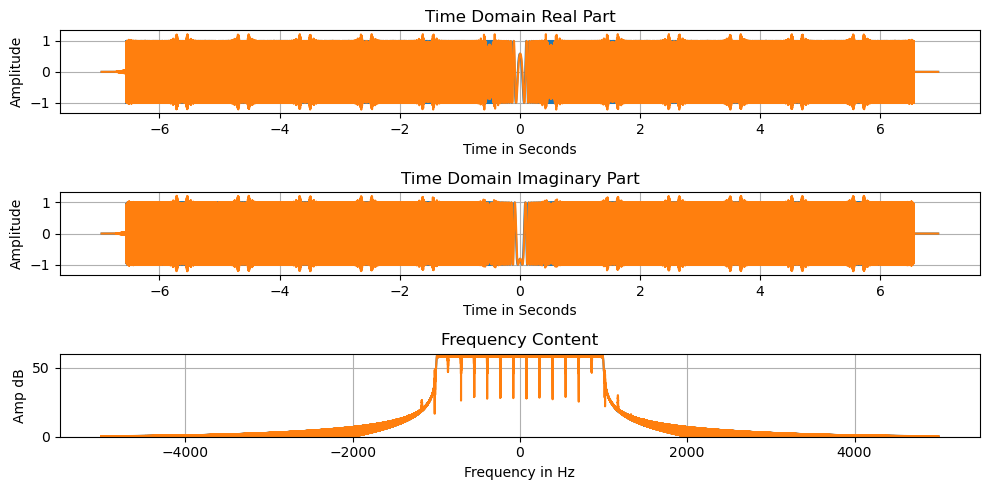

In [3]:
nchans = 64
nslice = 2048
fs = 10000
t_len = nchans * nslice / fs
bw = 2000
ntaps = 64
g_del = nchans * (ntaps - 1) // 2
nzeros = 2048

x_rec, t, x, xpfb = runchirptest(t_len, fs, bw, nzeros*2, nchans, nslice)
# x_rec = x_rec[:len(x)]

fig = plotdata(x, x_rec[:t.shape[0],:], t, t,nchans*ntaps)



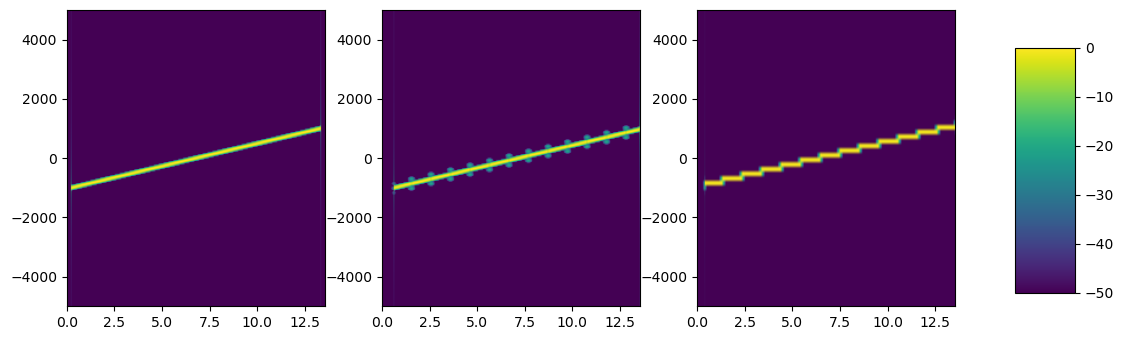

In [11]:
fig2 = plot_spectrogram(x, x_rec[:, 0], xpfb[:, :, 0])

(135168,)
(135168, 1)
(135168,)


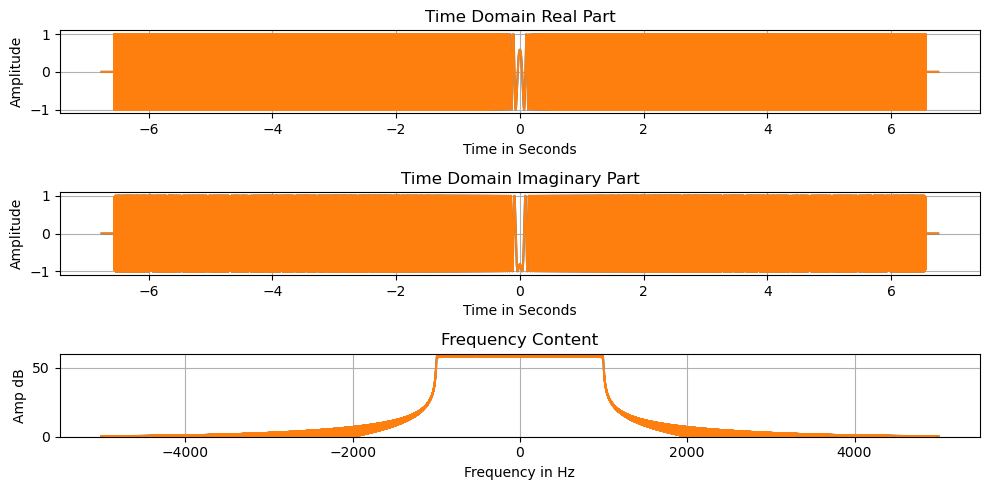

In [23]:

x_rec, t, x, xpfb = runnprchirptest(t_len, fs, bw, nzeros, nchans, nslice, ntaps)
x_rec = x_rec[: len(x), np.newaxis]  # need to add new axis due to plotting issue

fig = plotdata(x, x_rec, t, t, g_del)

print(x.shape)
print(x_rec.shape)
print(t.shape)

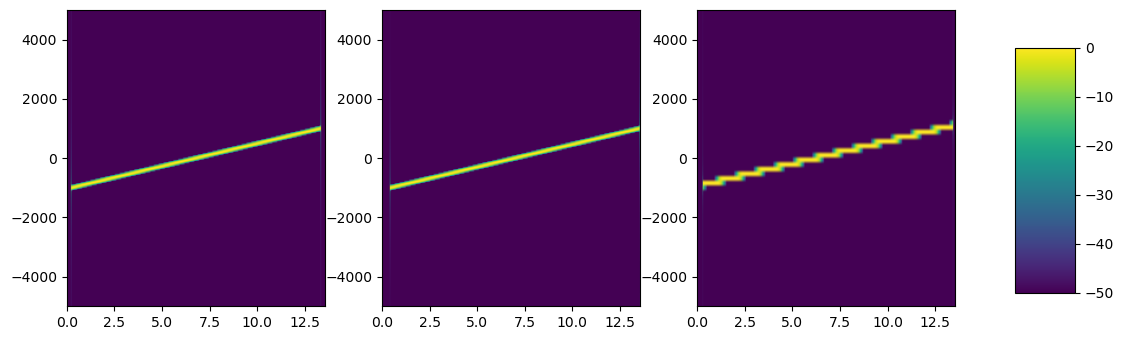

In [24]:
fig2 = plot_spectrogram(x, x_rec[:, 0], xpfb)